# 期中作业
### 数据来源：resst数据库 日股票综合数据（2021-）及中国居民消费价格指数CPI
### 沈子熙


In [260]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates

from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
#matplotlib inline
#config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_rows',8)
pd.set_option('display.max_columns', None)

## 基础数据

In [261]:
df = pd.read_csv('D:\github desktop\A-One-And-A-Two\期中作业\RESSET_DRESSTK_2021.csv')
df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df            

,Stkcd,PrevClPr,Oppr,Hipr,Lopr,Clpr,DFulTurnR,Dret,DRfRet,PE,PB
Date,,,,,,,,,,,
2021-01-04,1,19.34,19.10,19.10,18.44,18.60,0.8009,-0.0383,0.000075,12.48,1.07
2021-01-04,55,4.47,4.46,4.50,4.41,4.48,0.7650,0.0022,0.000075,12.76,0.82
2021-01-04,30,7.34,7.34,7.63,7.33,7.50,0.9431,0.0218,0.000075,15.07,1.69
2021-01-04,404,5.07,5.06,5.23,4.95,4.96,4.3395,-0.0217,0.000075,29.75,0.82
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30,35,5.38,5.35,5.44,5.30,5.33,4.7476,-0.0093,0.000068,101.35,0.98
2025-09-30,338,13.93,13.92,14.07,13.81,14.02,1.1463,0.0065,0.000068,10.96,0.85
2025-09-30,36,4.36,4.38,4.43,4.30,4.35,2.1907,-0.0023,0.000068,642.99,0.91
2025-09-30,96,11.28,11.27,11.50,11.17,11.37,1.4272,0.0080,0.000068,71.55,2.47


### 查看所有股票代码

In [262]:
sn = df['Stkcd'].unique()
print(f"\n数据中包含的股票数量：{len(sn)}")
print("股票代码列表：")
print(sn)


数据中包含的股票数量：89
股票代码列表：
[  1  55  30 404  50 159  62  29   6   4  28 407  61 153 338   8  27 408
 422  39  26 151  65  40  25  63 409 155 419  35 401  14  56 158   5 421
  34 402 157  58   9 400  59  32 420  31 403  89  12 416  90 156  60  37
  10  38  36   7  21 417  19  96  20  88  48  45 411   2  46 333  42  66
 100  69  70 301  11 410  23  49 413 166 415  16  17  99  78  68 150]


### 选你要的股票代码

In [263]:
target_stock_code = 35
# 筛选该股票的数据
df_1 = df[df['Stkcd'] == target_stock_code].copy()
print(f"\n筛选出的股票代码 {target_stock_code} ")
# 填充缺失值（平稳性检验）
df_1 = df_1.fillna(df_1.median())
print(df_1)


筛选出的股票代码 35 
            Stkcd  PrevClPr  Oppr  Hipr  Lopr  Clpr  DFulTurnR    Dret  \
Date                                                                     
2021-01-04     35      4.11  4.11  4.12  4.06  4.10     0.3150 -0.0024   
2021-01-05     35      4.10  4.09  4.15  4.06  4.15     0.2962  0.0122   
2021-01-06     35      4.15  4.15  4.15  4.08  4.10     0.2275 -0.0120   
2021-01-07     35      4.10  4.10  4.10  3.94  3.98     0.4669 -0.0293   
...           ...       ...   ...   ...   ...   ...        ...     ...   
2025-09-25     35      4.91  4.92  4.94  4.85  4.90     0.9396 -0.0020   
2025-09-26     35      4.90  4.90  5.11  4.87  4.99     1.9738  0.0184   
2025-09-29     35      4.99  5.16  5.49  5.10  5.38     6.3388  0.0782   
2025-09-30     35      5.38  5.35  5.44  5.30  5.33     4.7476 -0.0093   

              DRfRet      PE    PB  
Date                                
2021-01-04  0.000075   15.83  0.85  
2021-01-05  0.000075   16.02  0.85  
2021-01-06  0.000074   

### 月度,年度收益率

In [264]:
month_data = df_1.resample('ME')['Dret'].apply(lambda x: np.prod(1+x)-1).to_frame(name='Ret')
# 滚动年际收益率
month_data['Rolling_A_R'] = (1 + month_data['Ret']).rolling(window=12, min_periods=12).apply(lambda x: np.prod(x) - 1, raw=True)
#累积收益率
month_data['cum_return'] = (1 + df_1['Dret']).cumprod() - 1
year_data = df_1.resample('YE')['Dret'].apply(lambda x: np.prod(1+x)-1).to_frame(name='Ann')



month_data.index = pd.to_datetime(month_data.index)
year_data.index = pd.to_datetime(year_data.index)

month_data_1 = pd.merge_asof(month_data, year_data, left_index=True, right_index=True, direction='backward')

month_data_1

,Ret,Rolling_A_R,cum_return,Ann
Date,,,,
2021-01-31,-0.060835,NaN,NaN,NaN
2021-02-28,0.214985,NaN,NaN,NaN
2021-03-31,-0.018993,NaN,0.119399,NaN
2021-04-30,-0.093417,NaN,0.014827,NaN
...,...,...,...,...
2025-06-30,-0.016127,-0.048537,0.068496,-0.009535
2025-07-31,-0.000115,-0.069864,0.068373,-0.009535
2025-08-31,0.024770,0.036227,NaN,-0.009535
2025-09-30,0.222737,0.061778,0.338697,-0.009535


In [265]:
# 计算历史最高点
month_data_1['Peak'] = month_data_1['cum_return'].cummax() 
# 计算回撤
month_data_1['Drawdown'] = month_data_1['cum_return'] - month_data_1['Peak'] 
month_data_1

,Ret,Rolling_A_R,cum_return,Ann,Peak,Drawdown
Date,,,,,,
2021-01-31,-0.060835,NaN,NaN,NaN,NaN,NaN
2021-02-28,0.214985,NaN,NaN,NaN,NaN,NaN
2021-03-31,-0.018993,NaN,0.119399,NaN,0.119399,0.000000
2021-04-30,-0.093417,NaN,0.014827,NaN,0.119399,-0.104571
...,...,...,...,...,...,...
2025-06-30,-0.016127,-0.048537,0.068496,-0.009535,0.465627,-0.397131
2025-07-31,-0.000115,-0.069864,0.068373,-0.009535,0.465627,-0.397254
2025-08-31,0.024770,0.036227,NaN,-0.009535,NaN,NaN
2025-09-30,0.222737,0.061778,0.338697,-0.009535,0.465627,-0.126930


In [266]:
Pbpe = df_1.groupby(pd.Grouper(freq='ME')).agg({
            'PB': 'mean',
            'PE': 'mean'
        }).reset_index()
Pbpe["Date"] = pd.to_datetime(Pbpe["Date"],format='%Y-%m-%d')
Pbpe.set_index('Date', inplace=True)
Pbpe.sort_index(inplace=True)
Pbpe

,PB,PE
Date,,
2021-01-31,0.850000,15.435500
2021-02-28,0.850000,15.690667
2021-03-31,0.853913,17.933478
2021-04-30,0.940000,16.529524
...,...,...
2025-06-30,1.056000,58.804500
2025-07-31,0.980000,82.959565
2025-08-31,0.980000,83.145238
2025-09-30,0.980000,92.425455


### 引入cpi

In [267]:
cpi = pd.read_csv('D:\github desktop\A-One-And-A-Two\期中作业\cpi.csv')
cpi['EndDt'] = pd.to_datetime(cpi['EndDt'],format='%Y-%m-%d')
cpi.set_index('EndDt',inplace=True)
cpi

,CPI_YoY,CPIPPI_Dval
EndDt,,
1987-01-31,105.1,NaN
1987-02-28,105.4,NaN
1987-03-31,105.8,NaN
1987-04-30,106.7,NaN
...,...,...
2025-09-30,NaN,NaN
2025-10-31,NaN,NaN
2025-11-30,NaN,NaN
2025-12-31,NaN,NaN


In [268]:
month_data_1 = pd.merge(month_data_1, cpi, left_index=True, right_index=True,how='left')

month_data_1 = pd.merge(month_data_1, Pbpe, left_index=True, right_index=True,how='left')

month_data_1 = month_data_1.fillna(month_data_1.median())
month_data_1

,Ret,Rolling_A_R,cum_return,Ann,Peak,Drawdown,CPI_YoY,CPIPPI_Dval,PB,PE
Date,,,,,,,,,,
2021-01-31,-0.060835,0.002430,0.222181,-0.025807,0.461999,-0.204522,99.70,-0.6,0.850000,15.435500
2021-02-28,0.214985,0.002430,0.222181,-0.025807,0.461999,-0.204522,99.80,-1.9,0.850000,15.690667
2021-03-31,-0.018993,0.002430,0.119399,-0.025807,0.119399,0.000000,100.40,-4.0,0.853913,17.933478
2021-04-30,-0.093417,0.002430,0.014827,-0.025807,0.119399,-0.104571,100.90,-5.9,0.940000,16.529524
...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.016127,-0.048537,0.068496,-0.009535,0.465627,-0.397131,100.10,3.7,1.056000,58.804500
2025-07-31,-0.000115,-0.069864,0.068373,-0.009535,0.465627,-0.397254,100.00,3.6,0.980000,82.959565
2025-08-31,0.024770,0.036227,0.222181,-0.009535,0.461999,-0.204522,99.60,2.5,0.980000,83.145238
2025-09-30,0.222737,0.061778,0.338697,-0.009535,0.465627,-0.126930,100.45,2.4,0.980000,92.425455


In [269]:
#计算偏度
month_data_1['Ret'].skew()
# 计算峰度
month_data_1['Ret'].kurt()

0.46467828799841737

-0.21819281633259413

In [270]:
month_data_1['CPI_YoY'].skew()
month_data_1['CPI_YoY'].kurt()

0.6907443809583078

-0.4568028716943804

### 计算日度超额收益率，并以此计算月度已实现方差

In [271]:
# ER = 资产收益率 (Dret) - 无风险收益率 (DRfRet)
df_1['ER'] = df_1['Dret'] - df_1['DRfRet']
df_1['ER1'] = df_1['ER'].shift(1)
df_1['ER2'] = df_1['ER'].shift(2)
df_1['ER3'] = df_1['ER'].shift(3)
df_1

,Stkcd,PrevClPr,Oppr,Hipr,Lopr,Clpr,DFulTurnR,Dret,DRfRet,PE,PB,ER,ER1,ER2,ER3
Date,,,,,,,,,,,,,,,
2021-01-04,35,4.11,4.11,4.12,4.06,4.10,0.3150,-0.0024,0.000075,15.83,0.85,-0.002475,NaN,NaN,NaN
2021-01-05,35,4.10,4.09,4.15,4.06,4.15,0.2962,0.0122,0.000075,16.02,0.85,0.012125,-0.002475,NaN,NaN
2021-01-06,35,4.15,4.15,4.15,4.08,4.10,0.2275,-0.0120,0.000074,15.83,0.85,-0.012074,0.012125,-0.002475,NaN
2021-01-07,35,4.10,4.10,4.10,3.94,3.98,0.4669,-0.0293,0.000073,15.37,0.85,-0.029373,-0.012074,0.012125,-0.002475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-25,35,4.91,4.92,4.94,4.85,4.90,0.9396,-0.0020,0.000068,93.18,0.98,-0.002068,0.020732,-0.006268,0.002032
2025-09-26,35,4.90,4.90,5.11,4.87,4.99,1.9738,0.0184,0.000068,94.89,0.98,0.018332,-0.002068,0.020732,-0.006268
2025-09-29,35,4.99,5.16,5.49,5.10,5.38,6.3388,0.0782,0.000068,102.30,0.98,0.078132,0.018332,-0.002068,0.020732
2025-09-30,35,5.38,5.35,5.44,5.30,5.33,4.7476,-0.0093,0.000068,101.35,0.98,-0.009368,0.078132,0.018332,-0.002068


In [272]:
#  基于日度超额收益数据，计算月度的 “已实现方差（Realized Variance, RV）
MV = df_1.resample('ME').apply(lambda df: pd.Series({
    'RV': (df['ER']**2).sum(), 
    'RV1': (df['ER']**2).sum() + 2*(df['ER']*df['ER1']).sum(), # 扩展的已实现方差（加入 1 阶滞后交叉项）
    'RV1': (df['ER']**2).sum() + 2*(df['ER']*df['ER1']).sum(), 
    'RV2': (df['ER']**2).sum() + 2*(df['ER']*df['ER1']).sum() + 2*(df['ER']*df['ER2']).sum(),
    'RV3': (df['ER']**2).sum() + 2*(df['ER']*df['ER1']).sum() + 2*(df['ER']*df['ER2']).sum() + 2*(df['ER']*df['ER3']).sum()
}))
# 传统月度方差的计算
MV['var'] = df_1.resample('ME')['ER'].var()
MV.index.name = 'Date'

MV['RV1'] = MV['RV1'].where(MV['RV1']>=0, MV['RV'])
MV['RV2'] = MV['RV2'].where(MV['RV2']>=0, MV['RV1'])
MV['RV3'] = MV['RV3'].where(MV['RV3']>=0, MV['RV2'])
MV

,RV,RV1,RV2,RV3,var
Date,,,,,
2021-01-31,0.004699,0.004772,0.004954,0.005162,0.000237
2021-02-28,0.014210,0.025060,0.023254,0.020556,0.000824
2021-03-31,0.015460,0.006061,0.005198,0.005198,0.000702
2021-04-30,0.004727,0.001910,0.001736,0.004425,0.000214
...,...,...,...,...,...
2025-06-30,0.001320,0.001644,0.000933,0.000933,0.000069
2025-07-31,0.001831,0.001850,0.001651,0.002682,0.000083
2025-08-31,0.002264,0.000881,0.000740,0.001442,0.000112
2025-09-30,0.023434,0.014166,0.013467,0.025512,0.001020


In [273]:
month_data_1 = pd.merge(month_data_1, MV, left_index=True, right_index=True,how='left')

month_data_1 = month_data_1.fillna(month_data_1.median())
month_data_1

,Ret,Rolling_A_R,cum_return,Ann,Peak,Drawdown,CPI_YoY,CPIPPI_Dval,PB,PE,RV,RV1,RV2,RV3,var
Date,,,,,,,,,,,,,,,
2021-01-31,-0.060835,0.002430,0.222181,-0.025807,0.461999,-0.204522,99.70,-0.6,0.850000,15.435500,0.004699,0.004772,0.004954,0.005162,0.000237
2021-02-28,0.214985,0.002430,0.222181,-0.025807,0.461999,-0.204522,99.80,-1.9,0.850000,15.690667,0.014210,0.025060,0.023254,0.020556,0.000824
2021-03-31,-0.018993,0.002430,0.119399,-0.025807,0.119399,0.000000,100.40,-4.0,0.853913,17.933478,0.015460,0.006061,0.005198,0.005198,0.000702
2021-04-30,-0.093417,0.002430,0.014827,-0.025807,0.119399,-0.104571,100.90,-5.9,0.940000,16.529524,0.004727,0.001910,0.001736,0.004425,0.000214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.016127,-0.048537,0.068496,-0.009535,0.465627,-0.397131,100.10,3.7,1.056000,58.804500,0.001320,0.001644,0.000933,0.000933,0.000069
2025-07-31,-0.000115,-0.069864,0.068373,-0.009535,0.465627,-0.397254,100.00,3.6,0.980000,82.959565,0.001831,0.001850,0.001651,0.002682,0.000083
2025-08-31,0.024770,0.036227,0.222181,-0.009535,0.461999,-0.204522,99.60,2.5,0.980000,83.145238,0.002264,0.000881,0.000740,0.001442,0.000112
2025-09-30,0.222737,0.061778,0.338697,-0.009535,0.465627,-0.126930,100.45,2.4,0.980000,92.425455,0.023434,0.014166,0.013467,0.025512,0.001020


In [302]:
# 基本统计
returns_analysis = {}
returns_data = df_1['Dret'].dropna()
returns_analysis['基本统计'] = {
    '观测数': len(returns_data),
    '均值': returns_data.mean() * 100,
    '标准差': returns_data.std() * 100,
    '年化收益率': returns_data.mean() * 252 * 100,
    '年化波动率': returns_data.std() * np.sqrt(252) * 100,
    '最小值': returns_data.min() * 100,
    '最大值': returns_data.max() * 100,
    '偏度': returns_data.skew(),
    '峰度': returns_data.kurtosis()
}
returns_data

Date
2021-01-04   -0.0024
2021-01-05    0.0122
2021-01-06   -0.0120
2021-01-07   -0.0293
               ...  
2025-09-25   -0.0020
2025-09-26    0.0184
2025-09-29    0.0782
2025-09-30   -0.0093
Name: Dret, Length: 1160, dtype: float64

## 数据可视化

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Return')

Text(0, 0.5, 'Fitted Return')

Text(0.5, 1.0, 'Return: Monthly 1995-2021')

(array([18262., 18993., 19723., 20454.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18993.0, 0, '2022-01'),
  Text(19723.0, 0, '2024-01'),
  Text(20454.0, 0, '2026-01')])

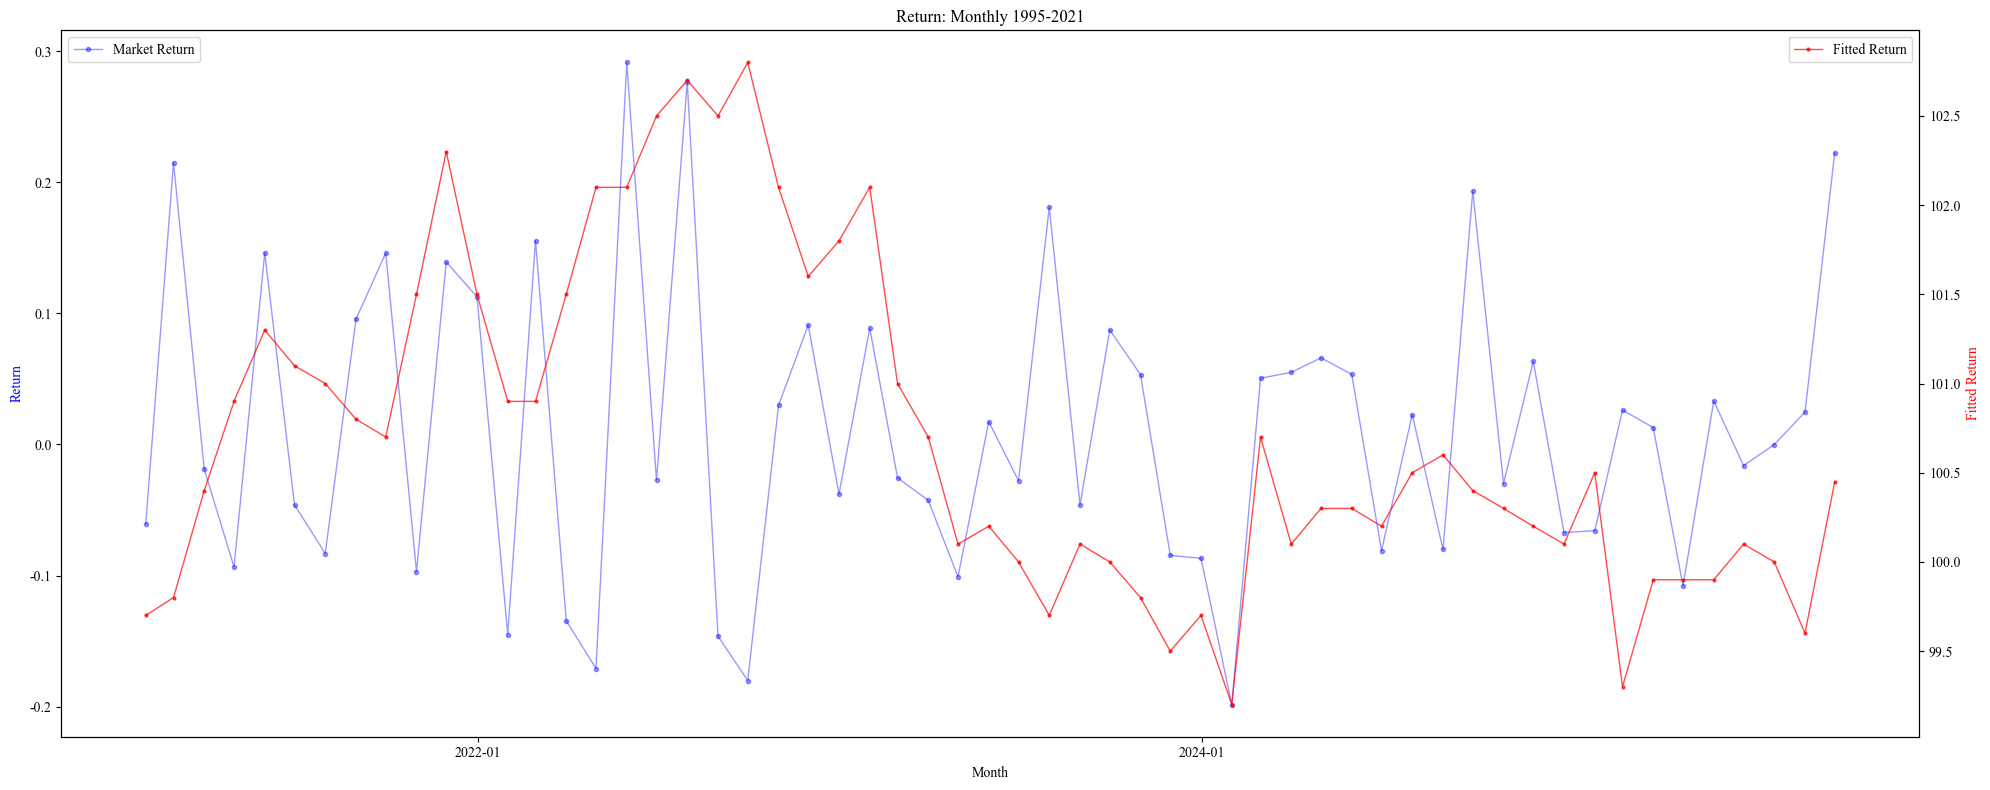

In [306]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定默认字体为黑体 (SimHei)，即可解决中文显示为□的问题
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 1, 1)  # 左轴（第一个Y轴）


ax.plot(
    month_data_1.index,  
    month_data_1['Ret'],
    color='blue',
    marker='.',
    linestyle='-',
    linewidth=1,
    markersize=6,
    alpha=0.4,
    label='Market Return'
)
ax.set_xlabel('Month')  # X轴标签
ax.set_ylabel('Return', color='blue')  # 左轴标签



ax2 = ax.twinx()  # 共享X轴
ax2.plot(
    month_data_1.index,  # X轴与左轴一致（必须用同一索引，保证时间对齐）
    month_data_1['CPI_YoY'],
    color='red',
    marker='o',
    linestyle='-',
    linewidth=1,
    markersize=2,
    alpha=0.7,
    label='Fitted Return'
)
ax2.set_ylabel('Fitted Return', color='red')  # 右轴标签



plt.title("Return: Monthly 1995-2021")
ax.legend(loc='upper left')  # 左轴图例（左上角）
ax2.legend(loc='upper right')  # 右轴图例（右上角，不重叠）

# 格式化X轴日期（避免拥挤）
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))  # 每2年显示一个刻度
plt.xticks(rotation=45)

plt.tight_layout()  #防止标签被截断
plt.show()

In [ ]:
def calculate_technical_indicators(data):
    df_tech = df_1.copy()
    
    # 移动平均线
    df_tech['MA_5'] = df_tech['Clpr'].rolling(window=5).mean()
    df_tech['MA_20'] = df_tech['Clpr'].rolling(window=20).mean()
    df_tech['MA_60'] = df_tech['Clpr'].rolling(window=60).mean()
    
    # RSI计算(相对强弱指数)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df_tech['RSI_14'] = calculate_rsi(df_tech['Clpr'])
    
    return df_tech
df_tech

,Stkcd,PrevClPr,Oppr,Hipr,Lopr,Clpr,DFulTurnR,Dret,DRfRet,PE,PB,ER,ER1,ER2,ER3,MA_5,MA_20,MA_60,RSI_14,BB_Middle,BB_Upper,BB_Lower,MACD,MACD_Signal,MACD_Histogram,Volatility_20d,Rolling_Mean_30d,Rolling_Std_30d
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,35,4.11,4.11,4.12,4.06,4.10,0.3150,-0.0024,0.000075,15.83,0.85,-0.002475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
2021-01-05,35,4.10,4.09,4.15,4.06,4.15,0.2962,0.0122,0.000075,16.02,0.85,0.012125,-0.002475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003989,0.000798,0.003191,NaN,NaN,NaN
2021-01-06,35,4.15,4.15,4.15,4.08,4.10,0.2275,-0.0120,0.000074,15.83,0.85,-0.012074,0.012125,-0.002475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003080,0.001254,0.001825,NaN,NaN,NaN
2021-01-07,35,4.10,4.10,4.10,3.94,3.98,0.4669,-0.0293,0.000073,15.37,0.85,-0.029373,-0.012074,0.012125,-0.002475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007240,-0.000445,-0.006796,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-25,35,4.91,4.92,4.94,4.85,4.90,0.9396,-0.0020,0.000068,93.18,0.98,-0.002068,0.020732,-0.006268,0.002032,4.858,4.7795,4.508000,58.695652,4.7795,5.213549,4.345451,0.112502,0.123218,-0.010715,46.542339,0.474667,2.498810
2025-09-26,35,4.90,4.90,5.11,4.87,4.99,1.9738,0.0184,0.000068,94.89,0.98,0.018332,-0.002068,0.020732,-0.006268,4.890,4.8110,4.519833,57.142857,4.8110,5.206602,4.415398,0.115292,0.121633,-0.006340,46.398117,0.497000,2.508216
2025-09-29,35,4.99,5.16,5.49,5.10,5.38,6.3388,0.0782,0.000068,102.30,0.98,0.078132,0.018332,-0.002068,0.020732,4.998,4.8575,4.537667,69.277108,4.8575,5.291229,4.423771,0.147275,0.126761,0.020514,52.687244,0.742333,2.842186
2025-09-30,35,5.38,5.35,5.44,5.30,5.33,4.7476,-0.0093,0.000068,101.35,0.98,-0.009368,0.078132,0.018332,-0.002068,5.102,4.8970,4.554167,67.251462,4.8970,5.352336,4.441664,0.166666,0.134742,0.031924,52.973672,0.719000,2.853295


<Axes: >

((array([-3.24013663, -2.97814901, -2.83215485, ...,  2.83215485,
          2.97814901,  3.24013663]),
  array([-0.1011, -0.1004, -0.0992, ...,  0.1007,  0.1008,  0.1009])),
 (0.023992652675128092, 0.000552844827586211, 0.9709454426954337))

Text(0.5, 1.0, 'Normality Test')

<Axes: >

Text(0.5, 1.0, 'Rolling30Daily Return Statistics')

Text(0.5, 0, 'Date')

Text(0, 0.5, ' % ')

(array([18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

<Axes: >

d:\anacond3\envs\MyMLenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anacond3\envs\MyMLenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28378 (\N{CJK UNIFIED IDEOGRAPH-6EDA}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anacond3\envs\MyMLenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anacond3\envs\MyMLenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anacond3\envs\MyMLenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from fo

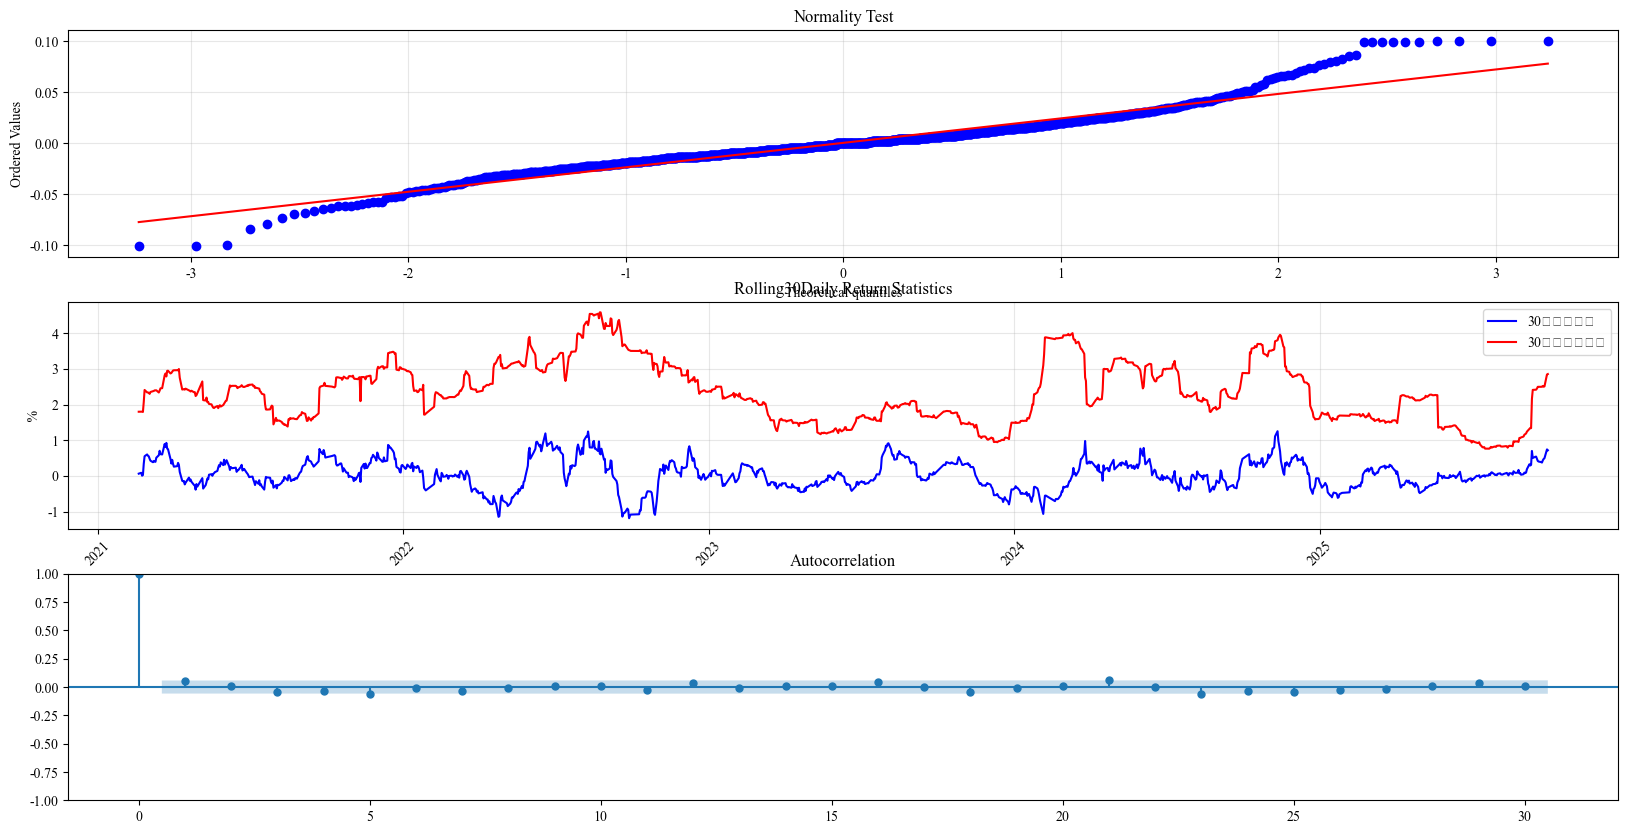

Text(0.5, 1.0, 'ACF')

Text(0.5, 4.4444444444444375, 'Lag Order')

Text(23.999999999999993, 0.5, 'Autocorrelation Coefficient')

C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\4280056791.py:34: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\4280056791.py:34: UserWarning: Glyph 28378 (\N{CJK UNIFIED IDEOGRAPH-6EDA}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\4280056791.py:34: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\4280056791.py:34: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\4280056791.py:34: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\4280056791.py:34: UserWarning: 

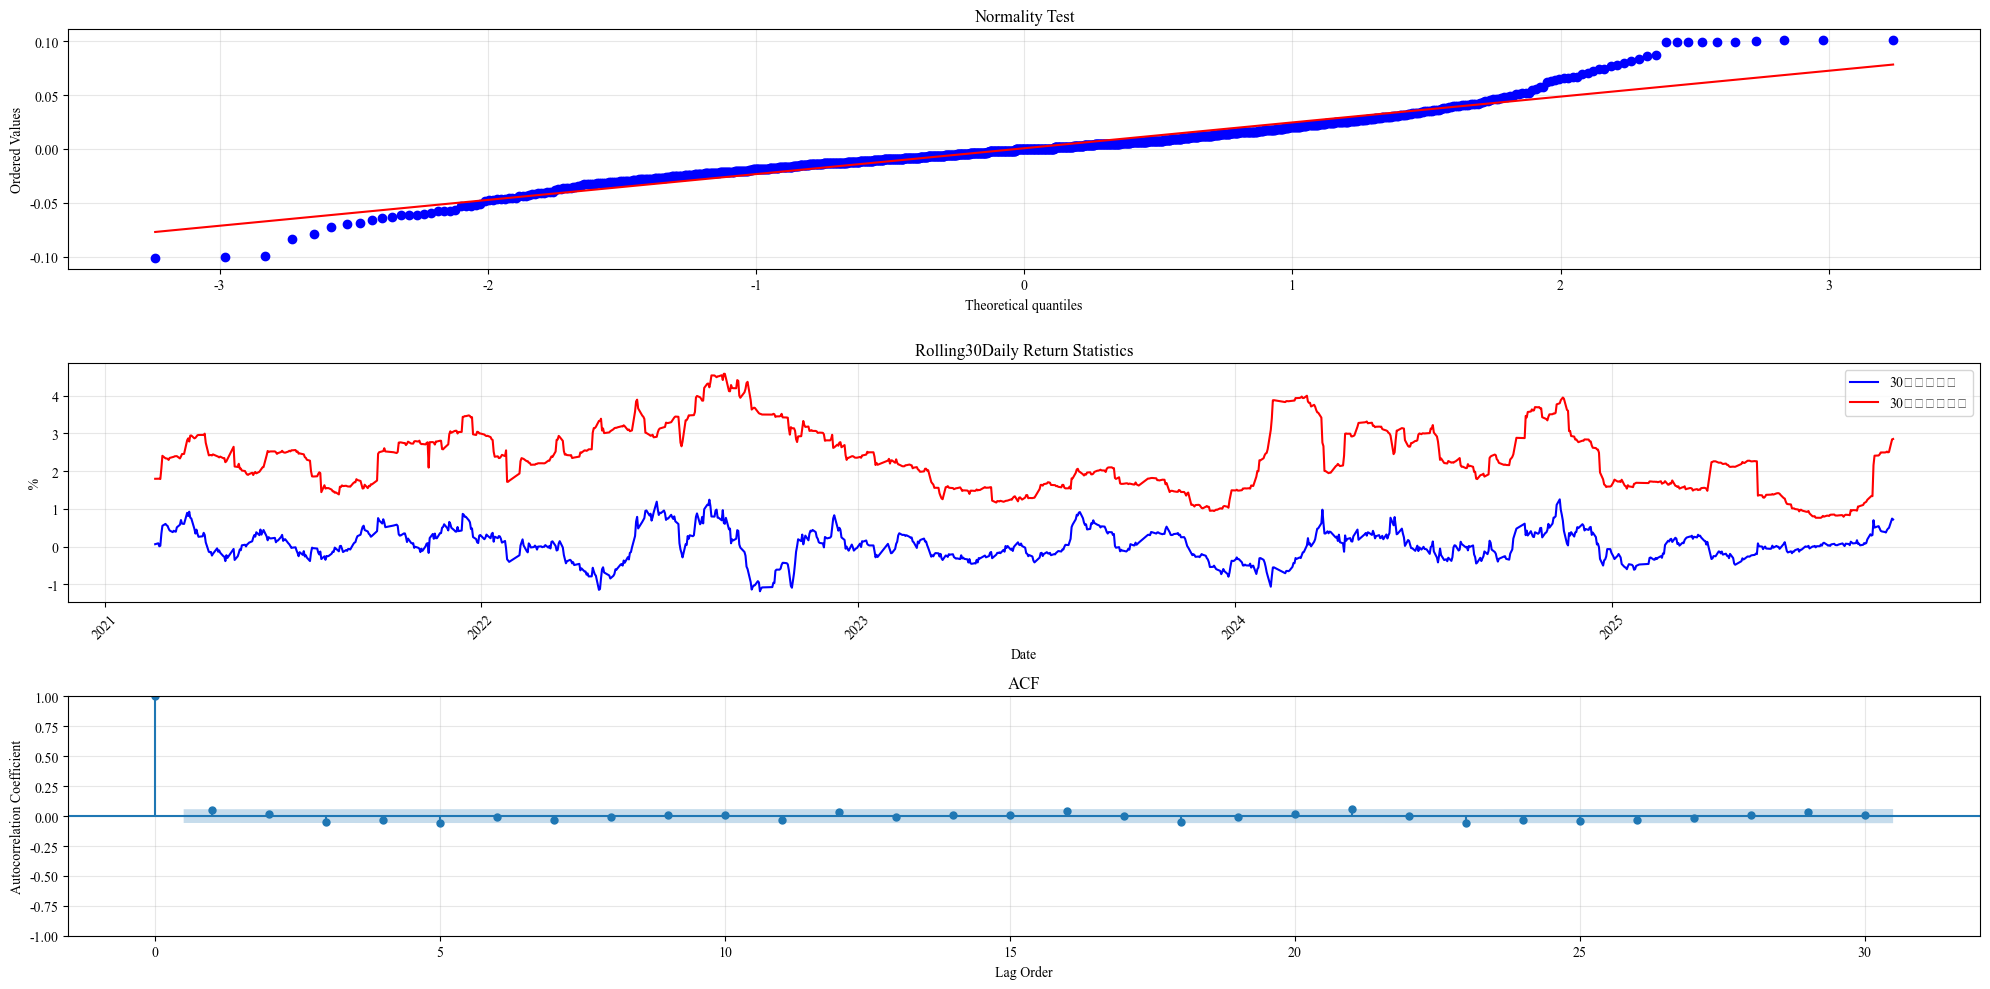

In [354]:
# 子图1: 正态性检验
fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1 , 1)
from scipy import stats
stats.probplot(returns_data, dist="norm", plot=plt)
plt.title('Normality Test')
plt.grid(True, alpha=0.3)

# 子图2: 滚动收益率统计
window = 30
df_tech[f'Rolling_Mean_{window}d'] = returns_data.rolling(window=window).mean() * 100
df_tech[f'Rolling_Std_{window}d'] = returns_data.rolling(window=window).std() * 100

plt.subplot(3, 1, 2)
plt.plot( df_tech[f'Rolling_Mean_{window}d'], label=f'{window}日滚动均值', color='blue')
plt.plot( df_tech[f'Rolling_Std_{window}d'], label=f'{window}日滚动标准差', color='red')
plt.title(f'Rolling{window}Daily Return Statistics')
plt.xlabel('Date')
plt.ylabel(' % ')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)


# 子图3: 收益率自相关分析
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(3, 1, 3)
plot_acf(returns_data, lags=30, ax=plt.gca(), alpha=0.05)
plt.title('ACF')
plt.xlabel('Lag Order')
plt.ylabel('Autocorrelation Coefficient')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Axes: >

Text(0.5, 1.0, 'MA')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

<Axes: >

Text(0.5, 1.0, 'RSI (14days)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'RSI')

(array([18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

<Axes: >

Text(0.5, 0, 'DFulTurnR (%)')

Text(0, 0.5, 'Dret (%)')

Text(0.5, 1.0, 'DFulTurnR vs Dret')

<Axes: >

Text(0.5, 1.0, 'ANN_Volatility (20d)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Volatilit (%)')

(array([18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\1823701386.py:49: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\1823701386.py:49: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\1823701386.py:49: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\1823701386.py:49: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\1823701386.py:49: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_35360\1823701386.py:49: UserWarning: 

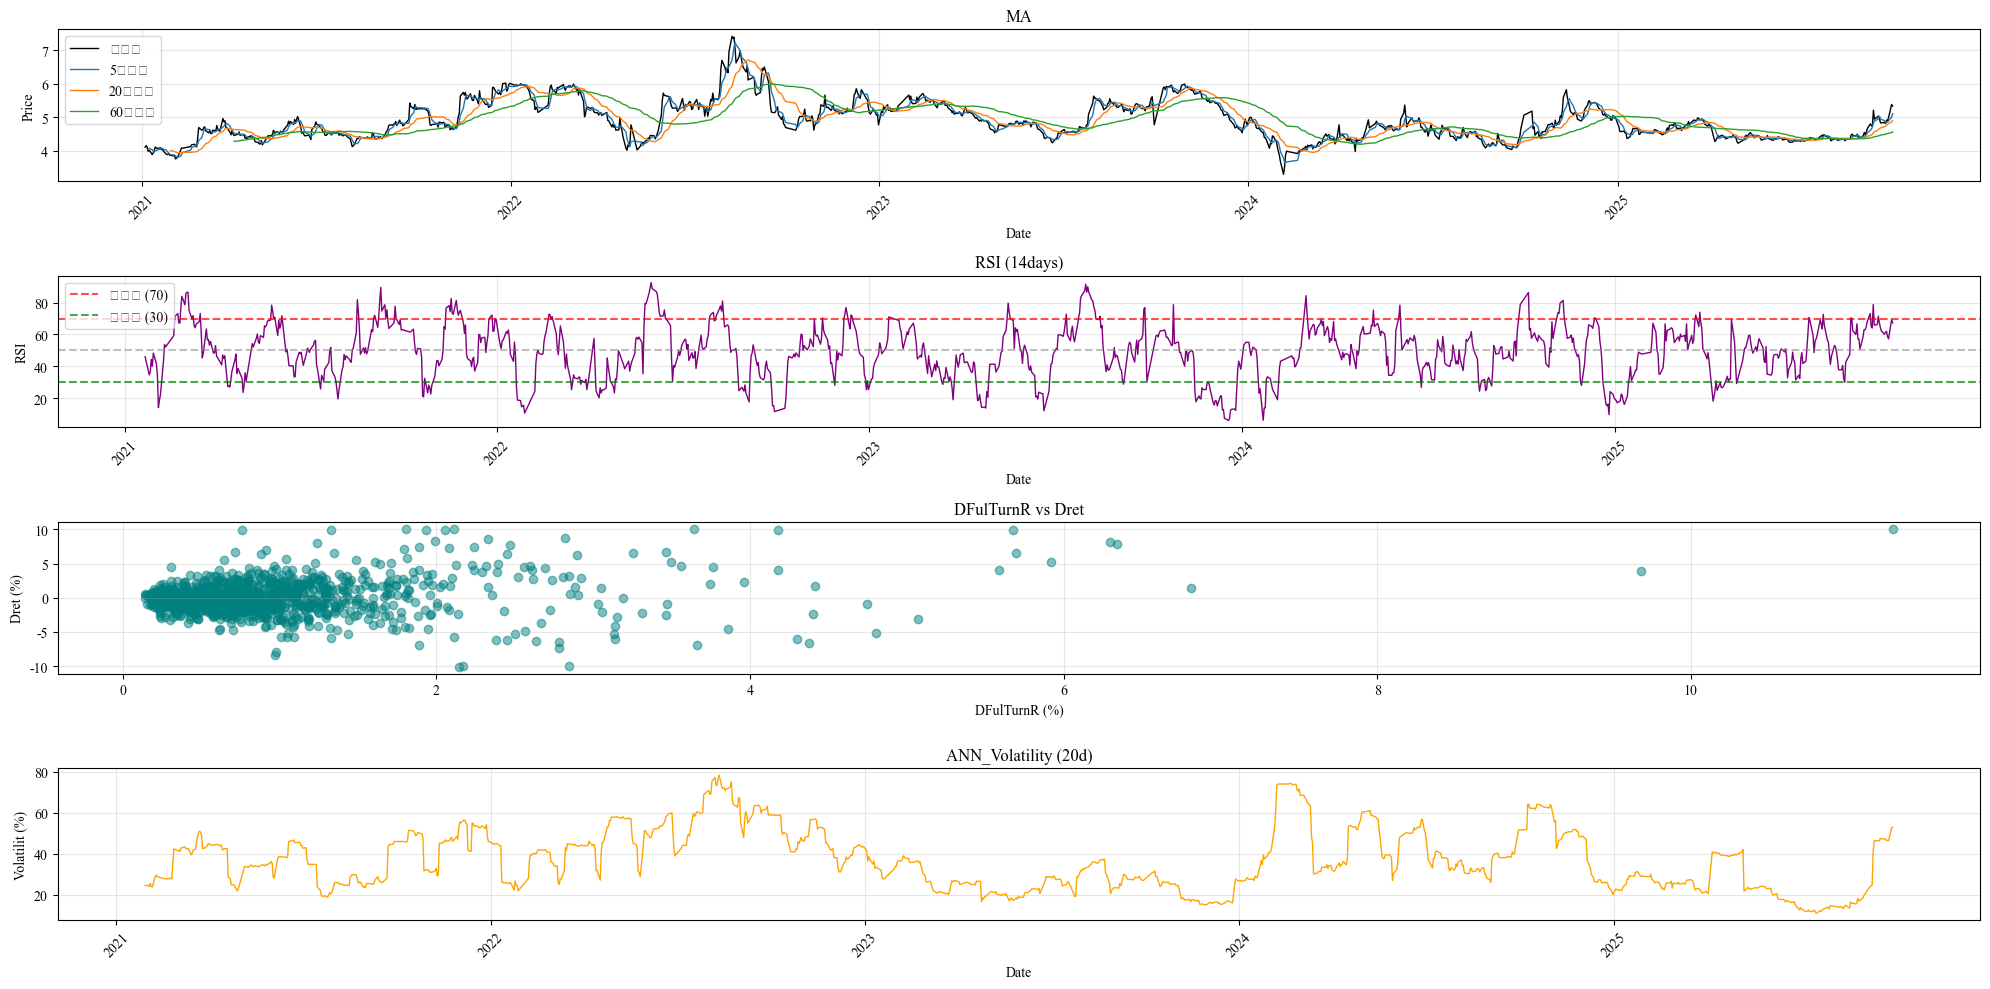

In [355]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
plt.rcParams['axes.unicode_minus'] = False

# 子图1: 价格与移动平均线
fig = plt.figure(figsize=(20, 10))
plt.subplot(4, 1, 1)
plt.plot(df_tech['Clpr'], label='收盘价', linewidth=1, color='black')
plt.plot(df_tech['MA_5'], label='5日均线', linewidth=1)
plt.plot(df_tech['MA_20'], label='20日均线', linewidth=1)
plt.plot(df_tech['MA_60'], label='60日均线', linewidth=1)
plt.title('MA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 子图2: RSI
plt.subplot(4, 1, 2)
plt.plot( df_tech['RSI_14'], color='purple', linewidth=1)
plt.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='超买线 (70)')
plt.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='超卖线 (30)')
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
plt.title('RSI (14days)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 子图2: 成交量与价格关系(散点图)
plt.subplot(4, 1, 3)
plt.scatter(df_tech['DFulTurnR'], df_tech['Dret'] * 100, alpha=0.5, color='teal')
plt.xlabel('DFulTurnR (%)')
plt.ylabel('Dret (%)')
plt.title('DFulTurnR vs Dret')
plt.grid(True, alpha=0.3)

# 子图3: 波动率 (20日滚动标准差)
df_tech['Volatility_20d'] = df_tech['Dret'].rolling(window=20).std() * np.sqrt(252) * 100
plt.subplot(4,1, 4)
plt.plot( df_tech['Volatility_20d'], color='orange', linewidth=1)
plt.title('ANN_Volatility (20d)')
plt.xlabel('Date')
plt.ylabel('Volatilit (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 平稳性检验

In [385]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对换手率数据进行ADF检验
adf_result = ADF(df_1['2021-01':'2025-08']['DFulTurnR'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -5.6779
p-value: 0.0000
Critical Values:
   1%: -3.4362
   5%: -2.8641
   10%: -2.5681
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [386]:
# 对月收益率数据进行ADF检验
adf_result = ADF(month_data_1['Ret'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -5.7112
p-value: 0.0000
Critical Values:
   1%: -3.5602
   5%: -2.9179
   10%: -2.5968
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [387]:
# 对cpi进行ADF检验
adf_result = ADF(month_data_1['CPI_YoY'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -2.1463
p-value: 0.2263
Critical Values:
   1%: -3.5529
   5%: -2.9147
   10%: -2.5951
结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。


In [388]:
adf_result = ADF(month_data_1['PB'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -2.2380
p-value: 0.1928
Critical Values:
   1%: -3.5602
   5%: -2.9179
   10%: -2.5968
结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。


In [389]:
adf_result = ADF(month_data_1['PE'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -1.7040
p-value: 0.4290
Critical Values:
   1%: -3.5529
   5%: -2.9147
   10%: -2.5951
结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。


#### CPI_YoY与PB和PE都非平稳

In [390]:
adf_result = ADF(month_data_1['RV'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -4.6342
p-value: 0.0001
Critical Values:
   1%: -3.5529
   5%: -2.9147
   10%: -2.5951
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


## OLS 回归结果

In [391]:
# 探究 居民消费价格指数同比增长率（CPI YoY）是否能预测未来的市场收益率
month_data_1['lCPI_YoY'] = month_data_1['CPI_YoY'].shift(2)
model_cpi = smf.ols('Ret~lCPI_YoY',
                    data=month_data_1).fit()
print(model_cpi.summary())

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                   0.04187
Date:                Tue, 18 Nov 2025   Prob (F-statistic):              0.839
Time:                        13:26:40   Log-Likelihood:                 42.432
No. Observations:                  55   AIC:                            -80.86
Df Residuals:                      53   BIC:                            -76.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3337      1.675     -0.199      0.8

In [392]:
month_data_1['lCPI_YoY'] = month_data_1['CPI_YoY'].shift(1)
month_data_1['lPE'] = month_data_1['PE'].shift(1)
month_data_1['lPB'] = month_data_1['PB'].shift(1)
model_cpi = smf.ols('Ret~lCPI_YoY + lPE + lPB ',
                    data=month_data_1).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_cpi.summary())
# 这个包含滞后 CPI、PE、PB 的模型，整体上是显著的，能够解释约 12.4% 的月度收益率变化

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     3.075
Date:                Tue, 18 Nov 2025   Prob (F-statistic):             0.0355
Time:                        13:26:40   Log-Likelihood:                 45.743
No. Observations:                  56   AIC:                            -83.49
Df Residuals:                      52   BIC:                            -75.39
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4464      1.401     -0.319      0.7

In [393]:
from statsmodels.iolib.summary2 import summary_col 
# 对原始数据（CPI, PD, PE, PB）进行滞后处理，生成用于预测的自变量
month_data_1['lcpi'] = month_data_1['CPI_YoY'].shift(2)
month_data_1['lPE'] = month_data_1['PE'].shift(1)
month_data_1['lPB'] = month_data_1['PB'].shift(1)
info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}"}
# 这 3 个模型用于单独评估每个指标的预测能力
model_pe = smf.ols('Ret ~ lPE', 
                 data=month_data_1).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_pb = smf.ols('Ret ~ lPB',
                 data=month_data_1).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_cpi = smf.ols('Ret ~ lcpi', # 用滞后 2 期的 CPI (lcpi) 预测 ret
                 data=month_data_1).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
# 这 1 个模型用于评估指标组合的预测能力
model_all = smf.ols('Ret ~ lPE + lPB + lcpi',
                 data=month_data_1).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})

results_table = summary_col(results=[model_pe, model_pb, model_cpi,model_all],
                            float_format='%0.3f', # 数据显示的格式，默认四位小数
                            stars=True, # 在显著的系数旁边显示星号（*）
                            model_names=['1', '2', '3','4','5','6'],
                            info_dict=info_dict, # 允许在表格底部添加额外的统计信息
                            regressor_order=['Intercept','lPE','lPB','lcpi']) # 强制指定表格中自变量（regressors）的显示顺序

results_table.add_title(
    'Table - OLS Regressions: Forecast Monthly Stock Market Return')

print(results_table)
# lPB的R-squared 为 0.113 (11.3%)，是所有单变量模型中最高的。lPB 是一个非常强有力的预测因子。

Table - OLS Regressions: Forecast Monthly Stock Market Return
                    1        2        3       4    
---------------------------------------------------
Intercept        0.026*  0.365***  -0.334  -0.248  
                 (0.015) (0.139)   (1.046) (1.022) 
lPE              -0.000                    0.000   
                 (0.000)                   (0.000) 
lPB                      -0.322***         -0.327**
                         (0.123)           (0.143) 
lcpi                               0.003   0.006   
                                   (0.010) (0.010) 
R-squared        0.007   0.113     0.001   0.093   
R-squared Adj.   -0.012  0.097     -0.018  0.040   
No. observations 56      56        55      55      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [394]:
model_cpi = smf.ols('Ret ~ RV',
                 data=month_data_1).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi.summary())

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     4.278
Date:                Tue, 18 Nov 2025   Prob (F-statistic):             0.0433
Time:                        13:26:40   Log-Likelihood:                 44.519
No. Observations:                  57   AIC:                            -85.04
Df Residuals:                      55   BIC:                            -80.95
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0225      0.013     -1.770      0.0

In [395]:
# 分别检验四种不同的滞后波动率指标对下一月度股票超额收益率的预测能力
month_data_1['lRV'] = month_data_1['RV'].shift(1)
month_data_1['lRV1'] = month_data_1['RV1'].shift(1)
month_data_1['lRV2'] = month_data_1['RV2'].shift(1)
month_data_1['lRV3'] = month_data_1['RV3'].shift(1)
model_qrv = smf.ols('Ret ~ lRV',
                 data=month_data_1).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_qrv1 = smf.ols('Ret ~ lRV1',
                 data=month_data_1).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_qrv2 = smf.ols('Ret ~ lRV2',
                 data=month_data_1).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_qrv3 = smf.ols('Ret ~ lRV3',
                 data=month_data_1).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})


# 将四个模型的详细回归结果（summary）依次打印出来。
print("=" * 80)
print("Model with lRV:")
print("=" * 80)
print(model_qrv.summary())
print("\n" + "=" * 80)
print("Model with lRV1:")
print("=" * 80)
print(model_qrv1.summary())
print("\n" + "=" * 80)
print("Model with lRV2:")
print("=" * 80)
print(model_qrv2.summary())
print("\n" + "=" * 80)
print("Model with lRV3:")
print("=" * 80)
print(model_qrv3.summary())


Model with lRV:
                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.044
Date:                Tue, 18 Nov 2025   Prob (F-statistic):              0.311
Time:                        13:26:40   Log-Likelihood:                 42.736
No. Observations:                  56   AIC:                            -81.47
Df Residuals:                      54   BIC:                            -77.42
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0365      0.028    

In [396]:
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
# 使用 stargazer 库将你之前运行的四个独立的回归模型的结果整合成一个清晰、专业、易于比较的表格
stargazer = Stargazer([model_qrv, model_qrv1, model_qrv2, model_qrv3])
stargazer.title("回归结果对比分析")
stargazer.custom_columns(['模型一', '模型二', '模型三', '模型四'])
stargazer.show_model_numbers(False) 
stargazer.show_confidence_intervals(False) 

# 生成HTML格式
html_output = stargazer.render_html()
HTML(html_output)

### GARCH-in-Mean 模型拟合

In [397]:
from arch.univariate import ARCHInMean, GARCH, Normal

garch_data = df_1.loc['2000-01-01':'2024-12-31', ['DFulTurnR']].copy() * 100
garch_data = garch_data.dropna()


print("GARCH(1,1)-in-Mean 模型估计")
print("="*80)

model_garch_m = ARCHInMean(garch_data['DFulTurnR'], volatility=GARCH())

res = model_garch_m.fit(disp='off')

print(res.summary())
#α +β =0.2184+0.6249=0.8433，小于 1，说明波动是平稳的，冲击会逐渐衰减。

GARCH(1,1)-in-Mean 模型估计
                      ARCH-in-mean - GARCH Model Results                      
Dep. Variable:              DFulTurnR   R-squared:                       0.000
Mean Model:              ARCH-in-mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -5276.15
Distribution:                  Normal   AIC:                           10562.3
Method:            Maximum Likelihood   BIC:                           10586.7
                                        No. Observations:                  977
Date:                Tue, Nov 18 2025   Df Residuals:                      975
Time:                        13:26:40   Df Model:                            2
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const        -13.3573     16.262     -0.821   